In [1]:
sc

In [2]:
# from pyspark import SparkConf, SparkContext

# # In Jupyter you have to stop the current context first
# sc.stop()

# # Create new config
# conf = (SparkConf()
#     .set("spark.driver.maxResultSize", "10g"))

# # Create new context
# sc = SparkContext(conf=conf)

In [3]:
import numpy as np
import matplotlib.pyplot as pl
from PIL import Image
%matplotlib inline

In [4]:
def distance(xs,ys,zs,x,y,z):

    dist = 1.0*((x - xs)**2 + (y - ys)**2 + (z - zs)**2)**0.5
    return dist

In [5]:
def in_picture(x,y,image_dimensions):
    # Check if point gets mapped to a pixel within the specified x and y
    # sizes of the image

    is_in_picture = (x < image_dimensions[0])*(x > 0)*(y > 0)*\
    (y < image_dimensions[1])

    return is_in_picture

In [6]:
def colin(params, xyz_a):

	# Unwrap params
	kappa, phi, omega, xs, ys, zs, f = params

	omega = float(omega)
	phi = float(phi) + 0.5*np.pi
	kappa = float(kappa)
	xs = float(xs)
	ys = float(ys)
	zs = float(zs)
	f = float(f)

	# -- utils
	co = np.cos(omega)
	so = np.sin(omega)
	cp = np.cos(phi)
	sp = np.sin(phi)
	ck = np.cos(kappa)
	sk = np.sin(kappa)

	a1 =  cp*ck+sp*so*sk
	b1 =  cp*sk+sp*so*ck
	c1 =  sp*co
	a2 = -co*sk
	b2 =  co*ck
	c2 =  so
	a3 =  sp*ck+cp*so*sk
	b3 =  sp*sk-cp*so*ck
	c3 =  cp*co

	ynum  = a1*(xyz_a[:,0]-xs)+b1*(xyz_a[:,1]-ys)+c1*(xyz_a[:,2]-zs)
	xnum  = a2*(xyz_a[:,0]-xs)+b2*(xyz_a[:,1]-ys)+c2*(xyz_a[:,2]-zs)
	denom = a3*(xyz_a[:,0]-xs)+b3*(xyz_a[:,1]-ys)+c3*(xyz_a[:,2]-zs)

	xx = -f*xnum/denom
	yy = f*ynum/denom

	return np.vstack([xx,yy]).T

In [61]:
def proj_npy(tile):
        

#     array=np.frombuffer(bytes(tile[1]))
#     dat = array[10:].reshape(-1, 3)

#    reshaped = (np.fromstring(tile)[10:]).reshape(-1,3)

    params = [1.345794960057916, 0.056072502823257861, -0.012072660480989369, 988504.86108153069,
              214494.40203705645, 799.41113612974959, 2831.8189679364423]

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])

    for fn, content in tile:   
        array=np.frombuffer(bytes(content))
        dat = array[10:].reshape(-1, 3)
 
        # Multiply by -1 because it apears as inverse; use orient?  
        pixel_xy = 1.0*colin(params, dat)

        # un-center pixel (x,y)
        x = image_dims[0]/2 + pixel_xy[:,0].astype(int)
        y = image_dims[1]/2 + pixel_xy[:,1].astype(int)

        is_in_picture = in_picture(x,y,image_dims)

        index = np.arange(is_in_picture.size)[is_in_picture>0]

        distgrid = np.ones(image_dims_reversed)*(100000.0)
        xgrid =  -1.*np.ones(image_dims_reversed)
        ygrid = -1.*np.ones(image_dims_reversed)

        if index.size==0:
            yield [distgrid, xgrid, ygrid]

        n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
        x   = x[index]
        y   = y[index]
        dat = dat[index]

        # Add each point to the arrays, given it is visibile (vis[i] == 1)
        # And it is closer to the camera than the current value stored in 
        # the corresponding pixel of the distance array

    #     nx = distgrid.shape[1]-1
    #     ny = distgrid.shape[0]-1

        for ii in range(index.size):
            if n[ii]<distgrid[y[ii], x[ii]] and n[ii]>100:
                distgrid[y[ii],x[ii]] = n[ii]
                xgrid[y[ii],x[ii]] = dat[ii,0]
                ygrid[y[ii],x[ii]] = dat[ii,1]


        yield [distgrid, xgrid, ygrid]

In [8]:
def merge(final, new):
    
    out = [0, 0, 0]
    replace = np.greater(final[0], new[0])
    out[0] = final[0]*np.logical_not(replace) + new[0]*replace
    out[1] = final[1]*np.logical_not(replace) + new[1]*replace
    out[2] = final[2]*np.logical_not(replace) + new[2]*replace
    
    return out

In [86]:
rddt = sc.binaryFiles('data_npy/', 78)
a = rddt.mapPartitions(proj_npy).treeReduce(merge)

In [87]:
a[0]

array([[ 100000.        ,  100000.        ,  100000.        , ...,
         100000.        ,  100000.        ,  100000.        ],
       [ 100000.        ,  100000.        ,  100000.        , ...,
         100000.        ,  100000.        ,  100000.        ],
       [ 100000.        ,  100000.        ,  100000.        , ...,
         100000.        ,  100000.        ,  100000.        ],
       ..., 
       [ 100000.        ,  100000.        ,    1877.15392188, ...,
           1850.05585854,    1850.51703118,    1849.74170392],
       [ 100000.        ,  100000.        ,    1876.25303054, ...,
         100000.        ,    1849.28033793,  100000.        ],
       [ 100000.        ,  100000.        ,    1875.35224018, ...,
           1848.04390037,  100000.        ,    1848.50503346]])

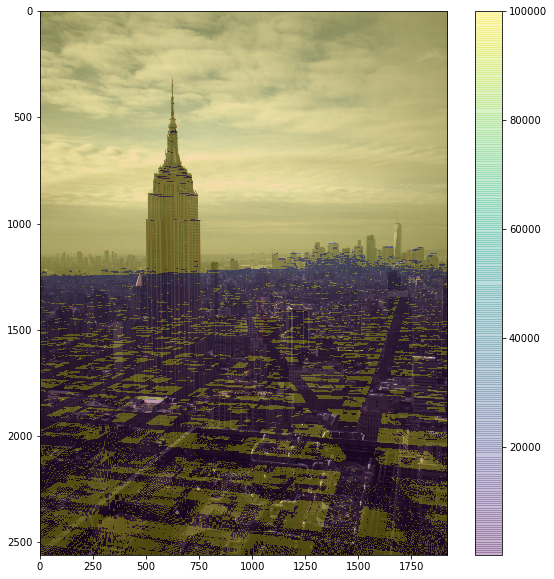

In [88]:
pl.figure(figsize=(10,10))

im = Image.open('./bof_left.png')
imarray = np.array(im)
# pl.imshow(imarray[900:1300, 1550:1850])
# pl.imshow(a[0][900:1300, 1550:1850], alpha=0.5)
pl.imshow(imarray)
pl.imshow(a[0], alpha=0.3)
pl.colorbar()




In [83]:
# np.save('distgrid_raw.npy', a[0])
# np.save('xgrid_raw.npy', a[1])
# np.save('ygrid_raw.npy', a[2])

In [89]:
final_grids = a

# Cascade to fill holes by covering a given point if there is 
# a closer point above it
print "Smoothing vertically..."
for i in range(0, len(final_grids[0])-1):
    for j in range(0, len(final_grids[0][0])):
        if final_grids[0][i][j] < final_grids[0][i + 1][j]:
            final_grids[0][i+1][j] = final_grids[0][i][j]
            final_grids[1][i+1][j] = final_grids[1][i][j]
            final_grids[2][i+1][j] = final_grids[2][i][j]

# Smooth pixels to get rid of vertical bars
print "Smoothing horizontally..."
for i in range(0, len(final_grids[0])-1):
    for j in range(1, len(final_grids[0][0])-2):
        if final_grids[0][i][j] != final_grids[0][i][j-1] and \
            final_grids[0][i][j+1] == final_grids[0][i][j+1]:
            final_grids[0][i][j] = final_grids[0][i][j+1]
            final_grids[1][i][j] = final_grids[1][i][j+1]
            final_grids[2][i][j] = final_grids[2][i][j+1]
# Smooth pixels two wide
print "Smoothing horizontally [2 pixels]..."
for i in range(0, len(final_grids[0])-1):
    for j in range(1, len(final_grids[0][0])-4):
        if final_grids[0][i][j] != final_grids[0][i][j-1] and \
            final_grids[0][i][j] == final_grids[0][i][j+1] and \
            final_grids[0][i][j-1] == final_grids[0][i][j+2]:
            final_grids[0][i][j] = final_grids[0][i][j+2]
            final_grids[1][i][j] = final_grids[1][i][j+2]
            final_grids[2][i][j] = final_grids[2][i][j+2]
            final_grids[0][i][j+1] = final_grids[0][i][j+2]
            final_grids[1][i][j+1] = final_grids[1][i][j+2]
            final_grids[2][i][j+1] = final_grids[2][i][j+2]


Smoothing vertically...
Smoothing horizontally...
Smoothing horizontally [2 pixels]...


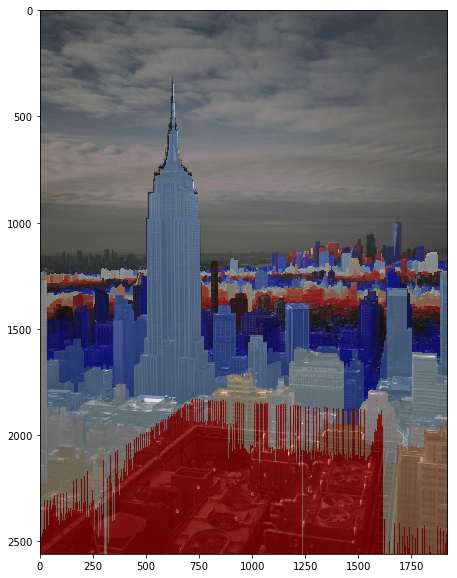

In [90]:
pl.figure(figsize=(10,10))

im = Image.open('./bof_left.png')
imarray = np.array(im)
# pl.imshow(imarray[900:1300, 1550:1850])
# pl.imshow(a[0][900:1300, 1550:1850], alpha=0.5)
pl.imshow(imarray, alpha=1)
pl.imshow(final_grids[0], alpha=0.4, cmap = 'flag')
#pl.colorbar()




In [92]:
# np.save('distgrid_cascade.npy', final_grids[0])
# np.save('xgrid_cascade.npy', final_grids[1])
# np.save('ygrid_cascade.npy', final_grids[2])